In [2]:

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import seaborn as sns
from collections import Counter

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from keras.utils import pad_sequences
from keras import mixed_precision
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk import FreqDist
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dense, Embedding, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
dfreviews=pd.read_csv('/content/Reviews.csv')
dfreviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
dfreviews.shape

(36305, 10)

In [5]:
dfreviews.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [6]:
dfreviews.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [7]:
dfreviews.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               1
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   1
Text                      0
dtype: int64

In [8]:
dfreviews.dropna(inplace=True)
dfreviews.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [9]:
dfreviews.drop(['Id','ProfileName'], axis=1, inplace=True)
dfreviews.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
dfreviews.columns

Index(['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [11]:
dfreviews.Text=dfreviews.Text.apply(str)
dfreviews.Summary=dfreviews.Summary.apply(str)

dfreviews['Text_Summary']=dfreviews[['Text','Summary']].agg(''.join, axis=1)
dfreviews.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_Summary
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy at a great price. There was a wid...


In [12]:
dfreviews.drop(['Text','Summary'],axis=1,inplace=True)
dfreviews.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text_Summary
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy at a great price. There was a wid...


In [13]:
# converting unix time to year/month/day format
dfreviews['Time_ymd']=dfreviews['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m-%d'))

# converting unix time to year/month format
dfreviews['Time_ym']=dfreviews['Time'].apply(lambda col: datetime.utcfromtimestamp(int(col)).strftime('%Y-%m'))

# Drop Time column
dfreviews.drop(['Time'] ,axis=1, inplace=True)
dfreviews.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text_Summary,Time_ymd,Time_ym
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,I have bought several of the Vitality canned d...,2011-04-27,2011-04
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012-09
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,This is a confection that has been around a fe...,2008-08-18,2008-08
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,If you are looking for the secret ingredient i...,2011-06-13,2011-06
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,Great taffy at a great price. There was a wid...,2012-10-21,2012-10


In [14]:
print('Earliest review-' ,dfreviews['Time_ymd'].min())
print('Latest review-' ,dfreviews['Time_ymd'].max())


Earliest review- 2000-06-23
Latest review- 2012-10-26


In [15]:
dfreviews['Helpfulness ratio'] = np.where(dfreviews['HelpfulnessDenominator'] > 0, dfreviews['HelpfulnessNumerator'] / dfreviews['HelpfulnessDenominator'],-1)

dfreviews.drop(['HelpfulnessNumerator','HelpfulnessDenominator'], axis=1, inplace=True)
dfreviews.head()

,ProductId,UserId,Score,Text_Summary,Time_ymd,Time_ym,Helpfulness ratio
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...,2011-04-27,2011-04,1.0
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012-09,-1.0
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...,2008-08-18,2008-08,1.0
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...,2011-06-13,2011-06,1.0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...,2012-10-21,2012-10,-1.0


In [16]:
dfreviews[dfreviews.duplicated(['ProductId','UserId'])].count()

ProductId            500
UserId               500
Score                500
Text_Summary         500
Time_ymd             500
Time_ym              500
Helpfulness ratio    500
dtype: int64

In [17]:
dfreviews.shape

(36303, 7)

In [18]:
dfreviews=dfreviews.drop_duplicates(subset=['ProductId','UserId'],keep='last' ,inplace=False)

In [19]:
dfreviews[dfreviews.duplicated(['UserId','ProductId'])].count()


ProductId            0
UserId               0
Score                0
Text_Summary         0
Time_ymd             0
Time_ym              0
Helpfulness ratio    0
dtype: int64

In [20]:
print('Shape of our dataset after removing duplicates')
dfreviews.shape

Shape of our dataset after removing duplicates


(35803, 7)

In [21]:
import re
import string

punctuation =  set(string.punctuation)
stop_words = set(stopwords.words("english"))
stop_words.update(["br", "href","good","great","amazon","product", "counter"])

def Clean_Text(review):
  x = review
  x = re.sub(r'https?:\S*', '', x)
  x = re.sub(r'{link}', '', x) #remove links
  x = re.sub(r'@[\w]*', '', x)
  x = re.sub(r'[^A-Za-z0-9]+', ' ', x)
  x = re.sub(r'\b[0-9]+\b', '', x)
  x = re.sub(r'&[a-z]+', '', x)
  x = ''.join(w for w in x if w not in punctuation)
  x = x.replace('[^a-zA-Z#]',' ') # Remove special

  x = [w.lower() for w in x.split() if w.lower() not in stop_words]
  x = [w for w in x if len(w) > 3]
  return x
  x=[w.lower() for w in x.split() if w.lower() not in stop_words]

# Apply the clean text on all reviews
dfreviews['Text_new']  = dfreviews['Text_Summary'].apply(lambda x: Clean_Text(x))
dfreviews.head()


,ProductId,UserId,Score,Text_Summary,Time_ymd,Time_ym,Helpfulness ratio,Text_new
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...,2011-04-27,2011-04,1.0,"[bought, several, vitality, canned, food, prod..."
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012-09,-1.0,"[arrived, labeled, jumbo, salted, peanuts, pea..."
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...,2008-08-18,2008-08,1.0,"[confection, around, centuries, light, pillowy..."
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...,2011-06-13,2011-06,1.0,"[looking, secret, ingredient, robitussin, beli..."
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...,2012-10-21,2012-10,-1.0,"[taffy, price, wide, assortment, yummy, taffy,..."


In [22]:
print(dfreviews['Text_new'][18])


['twizzlers', 'strawberry', 'childhood', 'favorite', 'candy', 'made', 'lancaster', 'pennsylvania', 'candies', 'oldest', 'confectionery', 'firms', 'united', 'states', 'subsidiary', 'hershey', 'company', 'company', 'established', 'young', 'smylie', 'also', 'make', 'apple', 'licorice', 'twists', 'green', 'color', 'blue', 'raspberry', 'licorice', 'twists', 'like', 'keep', 'cool', 'place', 'recommended', 'fridge', 'according', 'guinness', 'book', 'records', 'longest', 'licorice', 'twist', 'ever', 'made', 'measured', 'feet', 'weighted', 'pounds', 'made', 'candies', 'record', 'breaking', 'twist', 'became', 'guinness', 'world', 'record', 'july', 'kosher', 'thank', 'yougreat', 'sweet', 'candy']


Feature Engineering

In [23]:
dfreviews['Text_Length']=dfreviews['Text_new'].apply(lambda review:len(review))

In [24]:
dfreviews['Text_Length'].describe()

count    35803.000000
mean        34.898556
std         32.487710
min          3.000000
25%         16.000000
50%         25.000000
75%         43.000000
max        860.000000
Name: Text_Length, dtype: float64

Text(0.5, 1.0, 'Review length distribution')

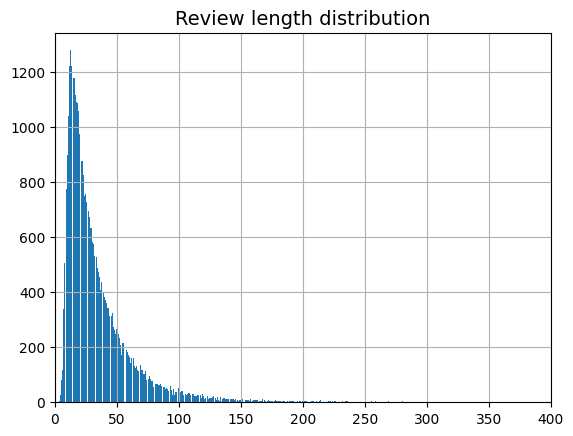

In [25]:
dfreviews['Text_Length'].hist(bins=1000)
plt.xlim(0,400)
plt.title('Review length distribution', fontsize=14)

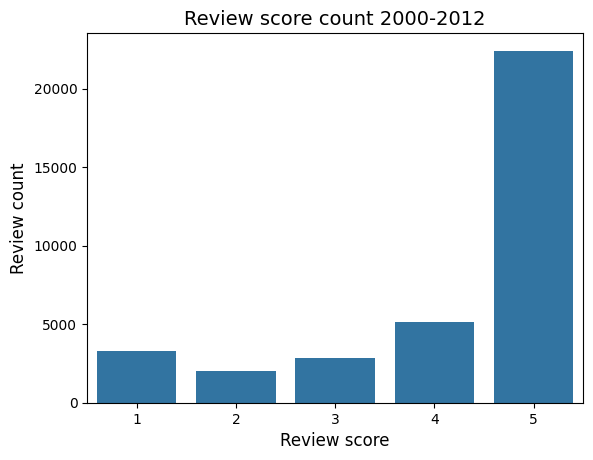

In [26]:
sns.countplot(x='Score',data=dfreviews);
plt.xlabel('Review score',fontsize=12)
plt.ylabel('Review count',fontsize=12)
plt.title('Review score count 2000-2012',fontsize=14)
plt.savefig('review_score_count_1999_2012.png')



In [27]:
def score_classification(score):

    if score > 3:
        return 1
    elif score == 3:
        return 2
    else:
        return 0

# Generate word cloud
def generate_word_cloud(Text):
    wordcloud = WordCloud(
        background_color='white',
        width = 1000,
        height = 500).generate(str(Text))
    fig = plt.figure(
        figsize = (10, 6),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [28]:
dfreviews['Sentiment']=dfreviews['Score'].apply(score_classification)
dfreviews.head()

,ProductId,UserId,Score,Text_Summary,Time_ymd,Time_ym,Helpfulness ratio,Text_new,Text_Length,Sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...,2011-04-27,2011-04,1.0,"[bought, several, vitality, canned, food, prod...",21,1
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012-09,-1.0,"[arrived, labeled, jumbo, salted, peanuts, pea...",17,0
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...,2008-08-18,2008-08,1.0,"[confection, around, centuries, light, pillowy...",40,1
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...,2011-06-13,2011-06,1.0,"[looking, secret, ingredient, robitussin, beli...",18,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...,2012-10-21,2012-10,-1.0,"[taffy, price, wide, assortment, yummy, taffy,...",12,1


In [29]:
dfreviews['Sentiment'].value_counts()

1    27589
0     5335
2     2879
Name: Sentiment, dtype: int64

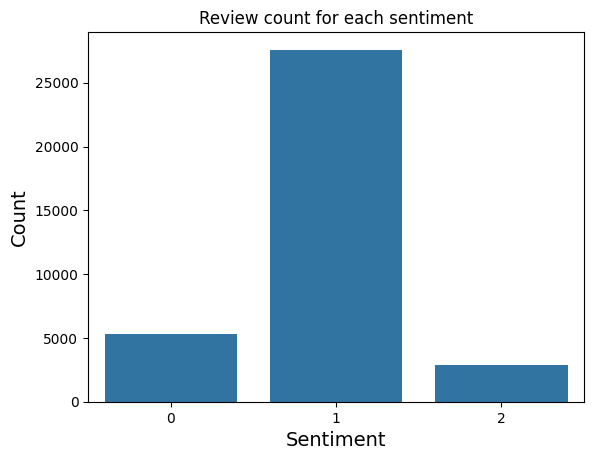

In [30]:
#Visualization of positive "1", negative "0" , and neutral "2" reviews
sns.countplot(x='Sentiment', data=dfreviews);
plt.xlabel('Sentiment',fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.title('Review count for each sentiment');

In [31]:
user_number_review=dfreviews.groupby(by=['UserId']).count().sort_values(by=['Text_new'],ascending=False)
user_number_review.head()


,ProductId,Score,Text_Summary,Time_ymd,Time_ym,Helpfulness ratio,Text_new,Text_Length,Sentiment
UserId,,,,,,,,,
A1Z54EM24Y40LL,30,30,30,30,30,30,30,30,30
AY12DBB0U420B,30,30,30,30,30,30,30,30,30
A3OXHLG6DIBRW8,22,22,22,22,22,22,22,22,22
A281NPSIMI1C2R,16,16,16,16,16,16,16,16,16
A31N6KB160O508,16,16,16,16,16,16,16,16,16


In [34]:
user_top_reviewer=user_number_review[user_number_review['Text_new']>10][['Text_new']]
user_top_reviewer.head(10)


,Text_new
UserId,
A1Z54EM24Y40LL,30
AY12DBB0U420B,30
A3OXHLG6DIBRW8,22
A281NPSIMI1C2R,16
A31N6KB160O508,16
A1YUL9PCJR3JTY,15
A3HPCRD9RX351S,12
A2SZLNSI5KOQJT,11
A1ZH9LWMX5UCFJ,11


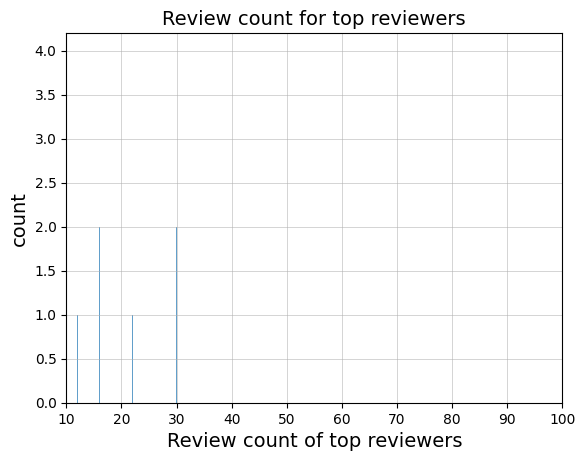

In [35]:
user_top_reviewer['Text_new'].hist(bins=400,label='Number of reviews for Top (>10) reviewer',alpha=0.7);
plt.xlabel('Review count of top reviewers',fontsize=14);
plt.ylabel('count',fontsize=14);

plt.grid(linewidth=0.5,alpha=0.75)

plt.xlim(10,100)
plt.title('Review count for top reviewers',fontsize=14);
plt.savefig('review_count_top_reviewer_dist.png')

In [36]:
user_top_reviewer['Text_new'].describe()


count    11.000000
mean     16.818182
std       7.332369
min      11.000000
25%      11.000000
50%      15.000000
75%      19.000000
max      30.000000
Name: Text_new, dtype: float64

In [37]:
user_average_info=dfreviews.groupby(by=['UserId']).mean()
user_average_info.head()

,Score,Helpfulness ratio,Text_Length,Sentiment
UserId,,,,
#oc-R119LM8D59ZW8Y,1.0,0.454545,153.0,0.0
#oc-R13X3YIJ6GLT0C,4.0,0.571429,331.0,1.0
#oc-R2HLGNHVIDQ0G1,4.0,0.571429,143.0,1.0
#oc-R3LI5WJM4WD02C,2.0,0.375000,80.0,0.0
A10012K7DF3SBQ,3.0,0.500000,26.0,2.0
